In [1]:
import cupy as cp
import numpy as np

from plot import points as plot_points
from utils import read_coo_array

/home/joel/Projects/gpu-umap-experiments/.venv/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:346: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/joel/Projects/gpu-umap-experiments/.venv/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:346: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/joel/Projects/gpu-umap-experiments/.venv/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:346: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc 

In [2]:
print("CuPy Custom Kernel Example")
print(f"GPU ID: {cp.cuda.Device().id}")

fss = read_coo_array("fss-1e5.arrow")
assert fss.shape[0] == fss.shape[1]

sources = cp.asarray(fss.row, dtype=cp.int32)
targets = cp.asarray(fss.col, dtype=cp.int32)
weights = cp.asarray(fss.data, dtype=cp.float32)
assert sources.shape == targets.shape

n_nodes = fss.shape[0]
n_edges = len(weights)

print(f"n_nodes: {n_nodes}, n_edges: {n_edges}")
print('sources', sources)
print('targets', targets)

assert np.all(sources < n_nodes)
assert np.all(targets < n_nodes)

CuPy Custom Kernel Example
GPU ID: 0
n_nodes: 100000, n_edges: 1502260
sources [    0     0     0 ... 99999 99999 99999]
targets [13811 13831 13832 ... 99261 99276 99472]


In [3]:
rand = np.random.RandomState(42)
initial_pos = np.column_stack((rand.random(n_nodes), rand.random(n_nodes)))
initial_pos *= 10
print("initial_pos:", initial_pos)

initial_pos: [[3.74540119 5.80779043]
 [9.50714306 5.2697165 ]
 [7.31993942 3.5103695 ]
 ...
 [6.74453407 1.92203677]
 [4.99447245 6.5308269 ]
 [3.89908485 0.01560081]]


In [4]:
from layout_cuda import layout
final_pos = layout(sources, targets, weights, initial_pos)
print("final_pos", final_pos)

Sampling 1,502,260 edges using custom kernel...
Grid: 46946 blocks × 32 threads
[0 0 0 ... 0 0 0] 48
sources [    0     0     0 ... 99999 99999 99999]
targets [13811 13831 13832 ... 99261 99276 99472]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 946.83it/s]

final_pos [[27.016342  8.959094]
 [27.001877  8.606765]
 [ 8.616096 16.767324]
 ...
 [27.050251  8.540736]
 [12.752228 26.872437]
 [18.60667   8.003025]]


<Axes: >

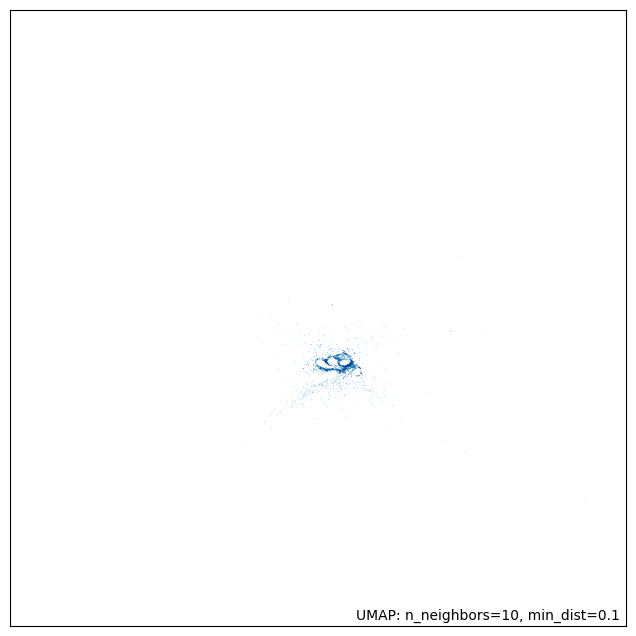

In [5]:
plot_points(final_pos, n_neighbors=10, min_dist=0.1)